# 심층 합성곱 생성적 적대 신경망 (Deep Convolutional Generative Adversarial Networks, DCGAN)

## 출처: [심층 합성곱 생성적 적대 신경망](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)

### 생성적 적대 신경망(GANs)
- 생성적 적대 신경망(Generative Adversial Networks, GANs)
- 두 개의 모델이 적대적인 과정을 통해 동시에 훈련
- 생성자(Generator): 진짜처럼 보이는 이미지를 생성하도록 배움
- 감별자(Discriminator): 가짜의 이미지로부터 진짜를 구별하게 되는 법을 배움

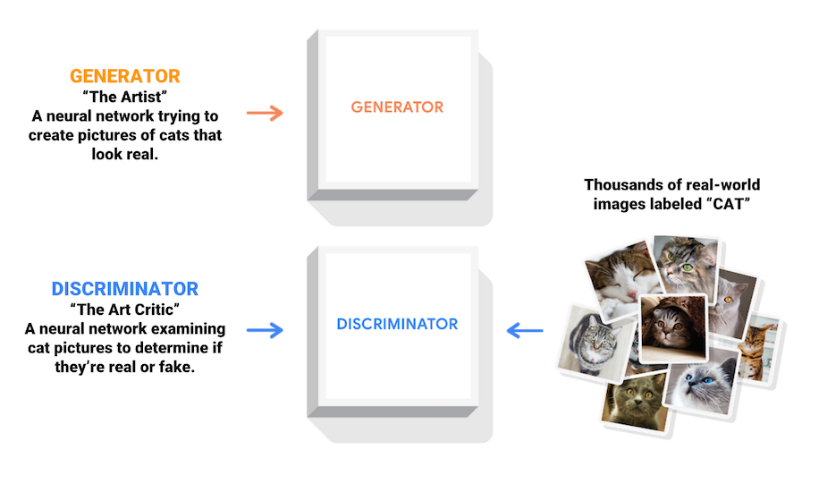

In [1]:
import os
from IPython.display import Image
Image("about_GANs.png")

- 훈련 과정 동안 생성자는 점차 실제같은 이미지를 더 잘 생성하게 됨
- 감별자는 점차 진짜와 가짜를 더 잘 구별하게 됨
- 이 과정에서 감별자가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될 때,
평형상태에 도달하게 됨

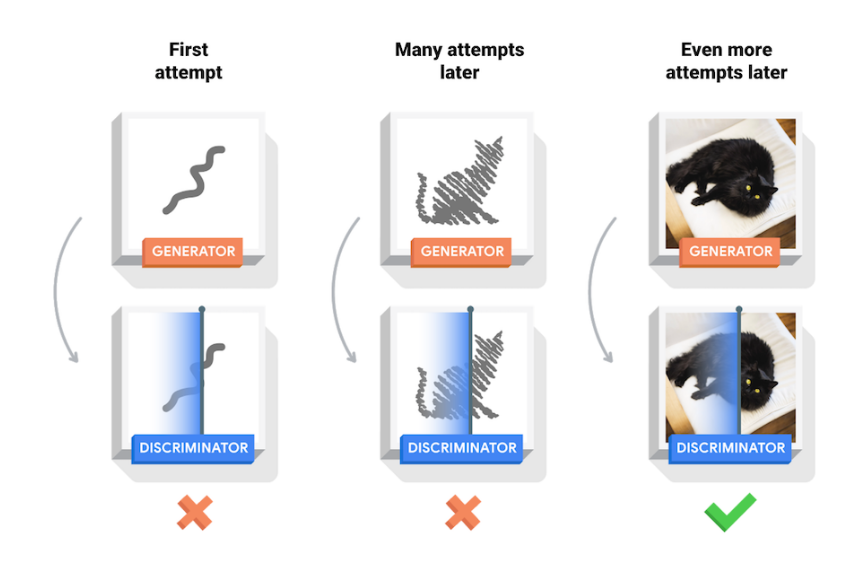

In [2]:
Image("GANs_training.png")

## DCGANs MNIST 생성 모델

### 0. GIF 생성을 위해 설치

In [3]:
# !pip install -q imageio

### 1. 라이브러리 불러오기

In [4]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

### 2. 데이터셋 로딩 및 준비

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
# float32 형태로 변환
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# 이미지 정규화
train_images = (train_images - 127.5) / 127.5

In [7]:
BUFFER_SIZE = 60000 # 60000번째 인덱스부터 buffer 보강
BATCH_SIZE = 256 # batch 개수

In [8]:
# 데이터 배치 생성 후 섞음
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 3. 모델 만들기
- 생성자/감별자는 Keras Sequential API를 이용해 정의

#### [1] 생성자
- 시드값(seed)으로부터 이미지를 생성하기 위해 업샘플링(tf.keras.layers.Conv2DTranspose) 층을 이용
- 1) 처음 Dense 층은 이 시드값을 입력값으로 받음
- 2) 원하는 사이즈(28x28x1)의 이미지가 나오도록 업샘플링 반복
- 3) tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 tf.keras.layers.LeakyReLU를 사용

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None --> BATCH_SIZE

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#### [1 - 1] 훈련되지 않은 생성자를 이용해 이미지 생성

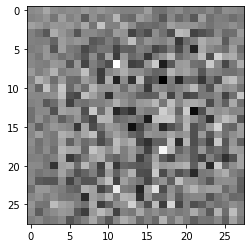

In [10]:
generator = make_generator_model() # 위에서 생성한 함수로 생성자 생성

noise = tf.random.normal([1, 100]) # 정규분포로부터 주어진 형태와 자료형을 갖는 [1,100] 형태의 난수 텐서 반환
# print(noise.shape) # (1, 100)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### [2] 감별자
- 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#### [2 - 1] 훈련되지 않은 감별자를 사용해 이미지의 진짜 여부 판별
- 모델은 진짜 이미지에는 양수의 값을, 가짜의 이미지에는 음수의 값을 출력되도록 훈련

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00369424]], shape=(1, 1), dtype=float32)


### 4. 손실함수와 옵티마이저 정의

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### [1] 감별자 손실함수
- 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화
- 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교
- 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬 비교

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### [2] 생성자 손실함수
- 생성자가 원활히 수행되고 있다면 감별자는 가짜 이미지를 진짜로 분류
- 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### [3] 감별자와 생성자의 옵티마이저

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 5. 체크포인트 저장
- 오랫동안 진행되는 훈련이 방해되는 경우에 유용하게 사용할 수 있음
- 모델의 저장 방법과 복구 방법

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 6. 훈련 루프 정의
- 생성자가 입력으로 랜덤 시드를 받는 것으로부터 훈련 루프 시작
- 시드값을 사용하여 이미지를 생성
- 감별자를 사용하여 진짜 이미지(훈련 세트에서 가져온 이미지)와 가짜 이미지(생성자로 생성한 이미지)를 분류
- 각 모델의 손실을 계산하고 gradients(그래디언트)를 사용해 생성자와 감별자 업테이트

In [18]:
# 변수 정의
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # 15번 반복할 때마다 모델 저장
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # 걸린 시간 출력
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 반복이 끝난 후 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

### 7. 이미지 생성 및 저장

In [21]:
def generate_and_save_images(model, epoch, test_input):
    # (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행-
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### 8. 모델 훈련
- 생성자와 갑별자가 서로 제압하지 않는 것이 중요
- 훈련 초반부에 생성된 이미지는 랜덤한 노이즈처럼 보이지만
- 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보임

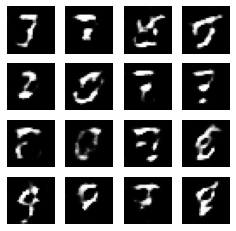

Time for epoch 20 is 273.66235542297363 sec


In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
### 마지막 체크포인트 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### 9. GIF 생성

In [ ]:
# 에포크 숫자를 사용하여 하나의 이미지 시각화
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
# imageio로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션 생성
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)